## Basic Setup

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os
import os.path as osp
import shutil
import sys

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as O
import torch.nn.functional as F
import torch.utils.data as D


from platform import python_version
print("Python Version", python_version())
print('PyTorch Version', torch.__version__)
print("Numpy Version", np.__version__)
print("Pandas Version", pd.__version__)
print("Matplotlib Version", matplotlib.__version__)

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.date_dayfirst', True)
pd.set_option('display.max_colwidth', None)

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

Python Version 3.7.13
PyTorch Version 1.10.0+cu111
Numpy Version 1.21.5
Pandas Version 1.3.5
Matplotlib Version 3.2.2


In [ ]:
# Reproduciblity
SEED = 1000
import random
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Number of Thread
NUM_CORES = 20
torch.set_num_threads(NUM_CORES)

In [ ]:
# Device to run on
DEVICE = 'cuda'
if DEVICE=='cuda':
    if torch.cuda.is_available():
        print('__CUDA VERSION', )
        from subprocess import call
        !nvcc --version
        print('__CUDNN VERSION:', torch.backends.cudnn.version())
        print('__Number CUDA Devices:', torch.cuda.device_count())
        print('__Devices')
        print('Active CUDA Device: GPU', torch.cuda.current_device())
        print ('Available devices ', torch.cuda.device_count())
        print ('Current cuda device ', torch.cuda.current_device())
    else:
        print("GPU not available")
        DEVICE = 'cpu'

print("\ndevice =", DEVICE)

GPU not available

device = cpu


## Prepare Environment & Agent

In [ ]:
def to_node_idx(side_length, x, y):
    if x + (side_length*y) < 0:
        print("ERROR: Node index is negative")
    return x + (side_length*y)

def to_coord(side_length, node_idx):
    return node_idx % side_length, node_idx // side_length

In [ ]:
class Gridworld:
    def __init__(self, side_length=20, agent_init_x=1, agent_init_y=1, num_apples=10, num_poisons=10, num_triggers=1, num_obstacles=0,
                 apple_reward=1.0, apple_sd=0.0, poison_reward=-1.0, poison_sd=0.0, prize_reward=5.0, prize_sd=0.0, wall_reward=0.0, wall_sd=0.0,
                 door_reward=10.0, door_sd=0.0, episode_length=6, plot_size=10):
    
        self.side_length = side_length
        self.num_states = self.side_length**2
        self.num_obstacles = num_obstacles
        self.num_apples = num_apples
        self.num_poisons = num_poisons
        self.num_triggers = num_triggers
        self.init_x = agent_init_x
        self.init_y = agent_init_y

        self.apple_reward = apple_reward
        self.apple_sd = apple_sd
        self.poison_reward = poison_reward
        self.poison_sd = poison_sd
        self.prize_reward = prize_reward
        self.prize_sd = prize_sd
        self.wall_reward = wall_reward
        self.wall_sd = wall_sd
        self.door_reward = door_reward
        self.door_sd = door_sd

        if (side_length-1)**2 < num_apples+num_poisons+num_obstacles+num_triggers+1:
            print("ERROR: Increase grid size")
        
        self.episode_length = episode_length
        self.plot_size = plot_size
        self.resetEnv()
        self.resetTime()


    # Reset time
    def resetTime(self):
        self.agent_x = self.init_x
        self.agent_y = self.init_y
        self.cum_reward = 0
        self.time = 0

        self.key_collected = False
        for (x,y) in self.triggers_on:
            self.triggers_off.add((x,y))
        self.triggers_on = set()
        for (x,y) in self.apples_dis:
            self.apples_vis.add((x,y))
        self.apples_dis = set()
        for (x,y) in self.poisons_dis:
            self.poisons_vis.add((x,y))
        self.poisons_dis = set()
        self.prize_collected = False
        self.door = (self.side_length-1, 1)
        if self.door in self.walls:
            self.walls.remove(self.door)


    # Reset the environment
    def resetEnv(self):
        self.walls = set([])
        for y in range(self.side_length):
            self.walls.add((0,y))
            self.walls.add((self.side_length-1,y))
        for x in range(self.side_length):
            self.walls.add((x,0))
            self.walls.add((x,self.side_length-1))

        self.door = (self.side_length-1, 1)
        
        self.key_collected = False
        self.key = (17, 3)

        self.prize = tuple(np.random.randint(low=1, high=self.side_length-1, size=2))
        while (self.prize==self.key) or (self.prize==(self.door[0]-1,self.door[1])):
            self.prize = tuple(np.random.randint(low=1, high=self.side_length-1, size=2))
        self.prize_collected = False
        
        self.triggers_off = set([])
        self.triggers_on = set([])
        while len(self.triggers_off) < self.num_triggers:
            x = np.random.randint(low=max(1,self.prize[0]-3), 
                                  high=min(self.side_length-1,self.prize[0]+3))
            y = np.random.randint(low=max(1,self.prize[1]-3), 
                                  high=min(self.side_length-1,self.prize[1]+3))
            if ((x,y) not in self.triggers_off) and ((x,y)!=self.key) and ((x,y)!=(self.door[0]-1,self.door[1])) and ((x,y)!=self.prize):
                self.triggers_off.add((x,y))
        
        self.obstacles = set([])
        while len(self.obstacles) < self.num_obstacles:
            x,y = np.random.randint(low=1, high=self.side_length-1, size=2)
            if ((x,y)!=self.key) and ((x,y) not in self.triggers_off) and ((x,y) not in self.obstacles) and (((x,y)!=(self.door[0]-1,self.door[1]))) and ((x,y)!=self.prize):
                self.obstacles.add((x,y))

        self.apples_vis = set([])
        self.apples_dis = set([])
        while len(self.apples_vis) < self.num_apples:
            x,y = np.random.randint(low=2, high=self.side_length-2, size=2)
            if ((x,y)!=self.key) and ((x,y) not in self.triggers_off) and ((x,y) not in self.obstacles) and ((x,y) not in self.apples_vis) and (((x,y)!=(self.door[0]-1,self.door[1]))) and ((x,y)!=self.prize) and (not (x>=14 and y<self.door[1]+5)):
                self.apples_vis.add((x,y))
        
        self.poisons_vis = set([])
        self.poisons_dis = set([])
        while len(self.poisons_vis) < self.num_poisons:
            x,y = np.random.randint(low=2, high=self.side_length-2, size=2)
            if ((x,y)!=self.key) and ((x,y) not in self.triggers_off) and ((x,y) not in self.obstacles) and ((x,y) not in self.apples_vis) and ((x,y) not in self.poisons_vis) and (((x,y)!=(self.door[0]-1,self.door[1]))) and ((x,y)!=self.prize) and (not (x>=14 and y<self.door[1]+5)):
                self.poisons_vis.add((x,y))
        
        
        self.walls.remove(self.door)

        if (self.init_x,self.init_y) in self.walls:
            print("ERROR: Agent initialised inside wall at (", self.init_x, ",", self.init_y, ")", sep="")


    # Accept an agent's action, return new state and reward
    # 0 = Up, 1 = Up-Right, 2 = Right, 3 = Down-Right, 4 = Down, 5 = Down-Left, 6 = Left, 7 = Up-Left
    def step(self, action):
        if self.time>=self.episode_length:
            return None, None
        self.time += 1
        new_x,new_y = self.agent_x,self.agent_y
        if action==0:
            new_y += 1
        elif action==1:
            new_x += 1
            new_y += 1
        elif action==2:
            new_x += 1
        elif action==3:
            new_x += 1
            new_y -= 1
        elif action==4:
            new_y -= 1
        elif action==5:
            new_x -= 1
            new_y -= 1
        elif action==6:
            new_x -= 1
        else:
            new_x -= 1
            new_y += 1
        
        if ((new_x,new_y)==self.key) and (self.key_collected==False):
            self.key_collected = True
            self.cum_reward += (self.door_reward + np.random.normal(loc=0.0, scale=self.door_sd))/10.0
        if (new_x,new_y) in self.triggers_off:
            self.triggers_on.add((new_x,new_y))
            self.triggers_off.remove((new_x,new_y))
            self.cum_reward = (self.prize_reward+np.random.normal(loc=0.0, scale=self.prize_sd))/10.0
        if (new_x,new_y) in self.poisons_vis:
            self.cum_reward += self.poison_reward+np.random.normal(loc=0.0, scale=self.poison_sd)
            self.poisons_vis.remove((new_x,new_y))
            self.poisons_dis.add((new_x,new_y))
        if (new_x,new_y) in self.apples_vis:
            self.cum_reward += self.apple_reward+np.random.normal(loc=0.0, scale=self.apple_sd)
            self.apples_vis.remove((new_x,new_y))
            self.apples_dis.add((new_x,new_y))
        if self.prize_collected==False and ((new_x,new_y)==self.prize):
            if len(self.triggers_on)==self.num_triggers:
                self.cum_reward += 9.0*(self.prize_reward+np.random.normal(loc=0.0, scale=self.prize_sd))/10.0
            else:
                self.cum_reward += (self.prize_reward+np.random.normal(loc=0.0, scale=self.prize_sd))/10.0
            self.prize_collected = True
        if (new_x,new_y)==self.door:
            if self.key_collected:
                self.cum_reward += 9.0*(self.door_reward + np.random.normal(loc=0.0, scale=self.door_sd))/10.0
            else:
                self.cum_reward += (self.door_reward + np.random.normal(loc=0.0, scale=self.door_sd))/10.0
            self.walls.add(self.door)
            self.door = (-1,-1)
        elif ((new_x,new_y) in self.walls):
            self.cum_reward += self.wall_reward+np.random.normal(loc=0.0, scale=self.wall_sd)
        else:
            if new_x<0 or new_y<0 or new_x>=self.side_length or new_y>=self.side_length:
                print("ERROR: Agent about to go out of grid from (", self.agent_x, ",", self.agent_y, ") to (", new_x, ",", new_y, ")", sep='')
                return None, None
            self.agent_x,self.agent_y = new_x,new_y

        r = 0
        if self.time>=self.episode_length:
            r = self.cum_reward
        return (self.agent_x,self.agent_y), r


    # Return the grid
    def getGrid(self):
        grid = []
        for r in range(self.side_length):
            row = []
            for c in range(self.side_length):
                x,y = c,r
                if (x,y)==(self.side_length-1, 1): # door
                    row.append(0.7)
                elif ((x,y) in self.walls) or ((x,y) in self.obstacles):
                    row.append(0.0)
                elif (x,y)==self.key:
                    row.append(0.5)
                elif ((x,y) in self.triggers_off) or ((x,y) in self.triggers_on):
                    row.append(0.6)
                elif ((x,y) in self.apples_vis) or ((x,y) in self.apples_dis):
                    row.append(0.3)
                elif ((x,y) in self.poisons_vis) or ((x,y) in self.poisons_dis):
                    row.append(0.2)
                elif (x,y)==self.prize:
                    row.append(0.4)
                else:
                    row.append(0.1)
            grid.append(row)
        return grid


    # Plot the grid
    def plotGrid(self,grid):
        cm = matplotlib.colors.ListedColormap(['black', 'white', 'blue', 'red', 'green', 'gold', 'lawngreen', 'grey', 'aqua', 'pink', 'brown'])
        plt.figure(figsize=(self.plot_size,self.plot_size))
        plt.pcolormesh(grid, edgecolors='black', cmap=cm, vmin=0.0, vmax=1.0)
        plt.axes().set_aspect('equal')
        plt.xticks([])
        plt.yticks([])
        # plt.axes().invert_yaxis()
        plt.show()

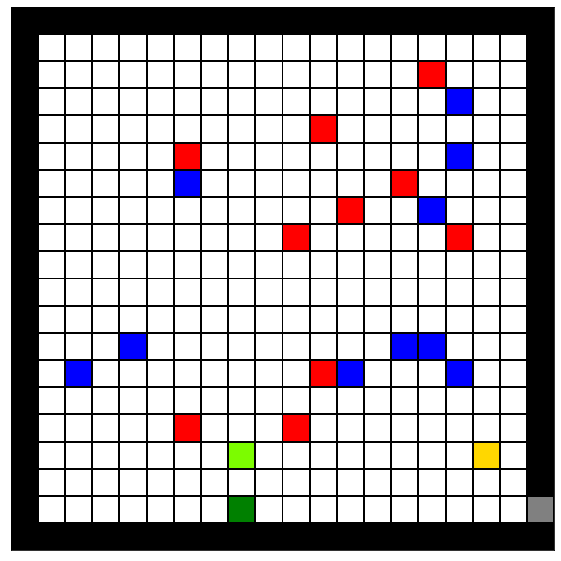

In [ ]:
env = Gridworld()
env.plotGrid(env.getGrid())

In [ ]:
class Agent:
    def __init__(self, num_states, num_actions=8, init_state=(1,1), buffer_limit=np.inf):
        self.init_state = init_state
        self.num_states = num_states
        self.num_actions = num_actions
        self.buffer_limit = buffer_limit

        self.reset()
        self.resetBuffer()
        self.initializePolicy()
    

    def reset(self):
        self.curr_exp = [[], [], []]
        self.state = self.init_state


    def resetBuffer(self):
        self.experience = [[], [], []]


    def initializePolicy(self):
        self.policy = {}
        random_actions = [1.0/float(self.num_actions) for a in range(self.num_actions)]
        for s in range(self.num_states):
            self.policy[s] = random_actions


    # Play an episode and store experience in buffer
    # Return this episode history as well
    # Assume agent.reset() and env.resetTime() both have been called immediately before
    def playEpisode(self, env):
        state = to_node_idx(env.side_length, self.state[0], self.state[1])
        actions = [i for i in range(self.num_actions)]

        self.curr_exp[0].append(state)
        while True:
            a = np.random.choice(a=actions, p=self.policy[state])
            self.state, r = env.step(a)
            if self.state==None or r==None:
                break
            self.curr_exp[1].append(a)
            self.curr_exp[2].append(r)
            state = to_node_idx(env.side_length, self.state[0], self.state[1])
            self.curr_exp[0].append(state)
        
        self.storeExperience()
        return self.curr_exp


    # Return an episode as 3 lists and episode index
    def sampleEpisode(self):
        if len(self.experience[0])==0:
            print("ERROR: Agent has no experience")
            return None, None, None, None

        episode_idx = np.random.randint(0,len(self.experience[0]))
        return self.experience[0][episode_idx], self.experience[1][episode_idx], self.experience[2][episode_idx], episode_idx


    # Store current experience in buffer
    def storeExperience(self):
        while len(self.experience[0]) >= self.buffer_limit:
            self.experience[0] = self.experience[0][1:]
            self.experience[1] = self.experience[1][1:]
            self.experience[2] = self.experience[2][1:]

        self.experience[0].append(self.curr_exp[0])
        self.experience[1].append(self.curr_exp[1])
        self.experience[2].append(self.curr_exp[2])

agent = Agent(env.side_length**2)

## Prepare traning pipleline

In [ ]:
def getLoss(pred, ground):
    pred = torch.sum(pred, dim=1)
    ground = torch.sum(ground, dim=1)
    t = torch.mean(torch.square(pred - ground))
    return t

## Setup & Train MLP

In [ ]:
class MLP(torch.nn.Module):
    def __init__ (self, num_states, hidden_size, out_size):
        super(MLP, self).__init__()
        self.lin1 = torch.nn.Linear(in_features=num_states, out_features=hidden_size, bias=True)
        self.lin2 = torch.nn.Linear(in_features=hidden_size, out_features=1, bias=True)
        self.num_states = num_states

    def forward(self, s):
        X = torch.nn.functional.one_hot(s, num_classes=self.num_states)
        X = X.type(torch.FloatTensor)
        X = torch.tanh(self.lin1(X))
        X = self.lin2(X)
        return X


MLPmodel = MLP(env.side_length**2, 64, 4).to(DEVICE)

In [ ]:
INIT_LR = 0.1
optimizer = torch.optim.Adam(MLPmodel.parameters(), lr=INIT_LR, betas=(0.9, 0.98), eps=1e-9, weight_decay=0, amsgrad=False)

def checkpoint():
    torch.save(MLPmodel.state_dict(), "MLPmodel.pt")
    print("Model checkpointed!")

# Multiply LR by factor if loss has not decayed by threshold for patience epochs
platLR = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=1e-4, 
                                                    threshold_mode='abs', cooldown=1, min_lr=0, eps=1e-12, verbose=False)

In [ ]:
print("Starting to train MLP...\n")
NUM_ITER = 80

best_loss = np.inf
MLPlosses = []
MLPmodel.train()
GAMMA = 0.1

for iter in range(1, NUM_ITER+1):
    agent.resetBuffer()

    for x in range(1,env.side_length-1):
        for y in range(1,env.side_length-1):
            env.init_x,env.init_y = x,y
            agent.init_state = (x,y)
            agent.reset()
            env.resetTime()
            ep = agent.playEpisode(env)

    states = torch.tensor(agent.experience[0]).to(DEVICE)
    actions = torch.tensor(agent.experience[1]).to(DEVICE)
    rewards = torch.tensor(agent.experience[2]).to(DEVICE)

    optimizer.zero_grad()

    pred = MLPmodel(states)

    pred = pred.reshape((pred.size(0),pred.size(1)))
    pred = pred[:,1:]

    loss = getLoss(pred, rewards)
    loss.backward()
    optimizer.step()

    platLR.step(loss)
    if len(MLPlosses)>0:
        L = (GAMMA*float(loss)) + ((1.0-GAMMA)*MLPlosses[-1])
    else:
        L = float(loss)
    MLPlosses.append(L)

    print("iter : "+str(iter)+" | loss : "+str(np.around(MLPlosses[-1], 6)))
    if iter>1 and best_loss > MLPlosses[-1]:
        checkpoint()
        best_loss = MLPlosses[-1]

Starting to train MLP...

iter : 1 | loss : 0.479969
iter : 2 | loss : 2.894847
Model checkpointed!
iter : 3 | loss : 5.749211
iter : 4 | loss : 6.203703
iter : 5 | loss : 5.658405
iter : 6 | loss : 5.515229
iter : 7 | loss : 5.229844
iter : 8 | loss : 4.738734
iter : 9 | loss : 4.774485
iter : 10 | loss : 5.084035
iter : 11 | loss : 4.785698
iter : 12 | loss : 4.493797
iter : 13 | loss : 4.579773
iter : 14 | loss : 4.439589
iter : 15 | loss : 4.040085
iter : 16 | loss : 3.915475
iter : 17 | loss : 3.863909
iter : 18 | loss : 3.612375
iter : 19 | loss : 3.313018
iter : 20 | loss : 3.181374
iter : 21 | loss : 3.083276
iter : 22 | loss : 2.967612
iter : 23 | loss : 2.827046
Model checkpointed!
iter : 24 | loss : 2.661253
Model checkpointed!
iter : 25 | loss : 2.475688
Model checkpointed!
iter : 26 | loss : 2.279557
Model checkpointed!
iter : 27 | loss : 2.081063
Model checkpointed!
iter : 28 | loss : 1.898564
Model checkpointed!
iter : 29 | loss : 1.735281
Model checkpointed!
iter : 30 |

## Plots

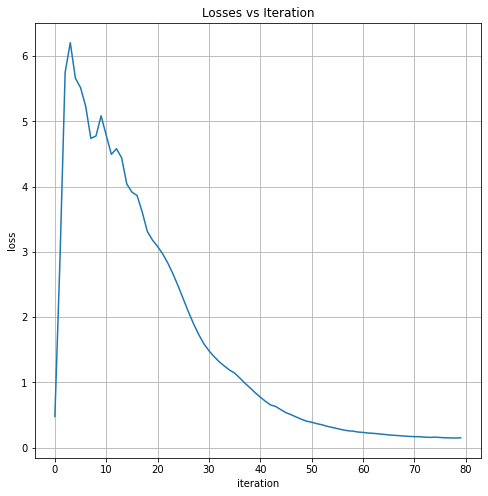

In [ ]:
plt.figure(figsize=(8,8))
plt.plot([i for i in range(len(MLPlosses))], MLPlosses)
plt.title("Losses vs Iteration")
plt.xlabel('iteration')
plt.ylabel('loss')
# plt.yscale('log')
plt.grid()
plt.show()

In [ ]:
MLPmodel.eval()
def getAllRewards(model = MLPmodel):
    s = torch.arange(start=0, end=env.side_length**2, step=1, dtype=torch.long, device=DEVICE)
    # print("s.size =", s.size())
    s = s.reshape((1,s.size(0)))
    # print("s.size =", s.size())
    r = model.forward(s)
    return r


def plotStates(grid, rewards, softmax=True):
    matrix = np.array([[float(rewards[to_node_idx(env.side_length, i,j)].cpu().detach().numpy()) for i in range(1,env.side_length-1)] for j in range(1,env.side_length-1)])
    cm = sns.light_palette("blue", as_cmap=True)
    x = pd.DataFrame(matrix).iloc[::-1]
    x = x.style.background_gradient(cmap=cm, axis=None)
    display(x)
    return x


def plotStatesSmall(c):
    color_list = list(c.ctx.values())
    color_list = sorted([str(key[0][1]) for key in color_list])
    color_list.append('black')
    cm = matplotlib.colors.ListedColormap(color_list)
    color2idx = {}
    for i,color in enumerate(color_list):
        color2idx[color] = i

    grad_plot = [[max(color2idx.values())+1 for i in range(env.side_length)] for j in range(env.side_length)]
    data = [[0.0 for i in range(env.side_length)] for j in range(env.side_length)]
    for key in c.ctx.keys():
        x = int(key[0])+1
        y = int(key[1])+1
        color = str(c.ctx[key][0][1])
        grad_plot[x][y] = color2idx[color]

    plt.figure(figsize=(env.plot_size,env.plot_size))
    plt.pcolormesh(grad_plot, edgecolors='black', cmap=cm, vmin=min(color2idx.values()), vmax=max(color2idx.values())+1)
    plt.axes().set_aspect('equal')
    plt.xticks([])
    plt.yticks([])
    plt.axes().invert_yaxis()
    plt.show()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
17,-0.032129,0.039575,-0.008930,0.030320,0.000246,-0.144987,0.096160,-0.174249,-0.078360,0.071869,-0.106299,0.033417,0.164636,-0.091960,-0.081363,0.004314,0.015059,-0.123770
16,-0.048868,-0.065588,0.016948,-0.011135,0.113069,-0.008983,0.026370,0.169026,0.010144,-0.155052,-0.167308,0.176665,-0.133349,0.062274,0.614995,0.070234,-0.146733,0.041795
15,0.002077,0.058500,-0.025881,-0.097402,-0.120160,0.009045,0.029026,-0.000269,0.161481,0.215185,0.196778,0.199507,-0.169789,0.244060,-0.119426,-0.331369,0.046137,0.048165
14,0.045044,-0.043932,0.116282,0.122976,0.096345,0.123174,-0.182235,0.011972,-0.100292,-0.159467,0.651418,0.003564,-0.072176,-0.165272,-0.094747,-0.136451,-0.157252,0.009540
13,-0.032053,-0.036157,-0.032798,-0.132361,0.016049,0.652593,-0.060471,0.093257,-0.097089,-0.073047,-0.009663,-0.025229,0.027354,0.028560,-0.015562,-0.417276,-0.064096,0.045822
12,-0.008437,0.065293,-0.019287,-0.021764,-0.008042,-0.636678,0.187642,-0.062177,0.175797,-0.192975,0.192355,-0.125988,0.167958,0.536566,-0.069912,-0.236836,-0.166581,-0.003321
11,0.001288,-0.024560,-0.026765,0.011471,-0.168739,-0.046454,-0.214876,0.095724,0.075338,-0.247120,0.140647,0.607101,-0.190330,-0.100402,-0.434819,-0.233887,-0.031872,0.144283
10,-0.064764,0.051482,-0.111248,0.007699,0.088841,-0.066391,-0.043949,0.063919,0.090215,0.619698,0.194095,0.201377,0.165526,-0.008106,0.111005,0.536786,0.070719,0.000782
9,0.036116,0.087095,-0.146736,0.138970,0.032352,0.086561,-0.110030,0.090037,0.072027,-0.162989,-0.065628,-0.097751,-0.100677,-0.087504,0.036683,0.129497,-0.071464,0.040521
8,0.016363,0.045890,0.039149,0.005904,-0.222678,-0.129157,-0.002938,0.184531,-0.159085,-0.198857,0.123553,-0.070557,0.099293,0.016519,0.057001,0.020353,0.000195,0.045183


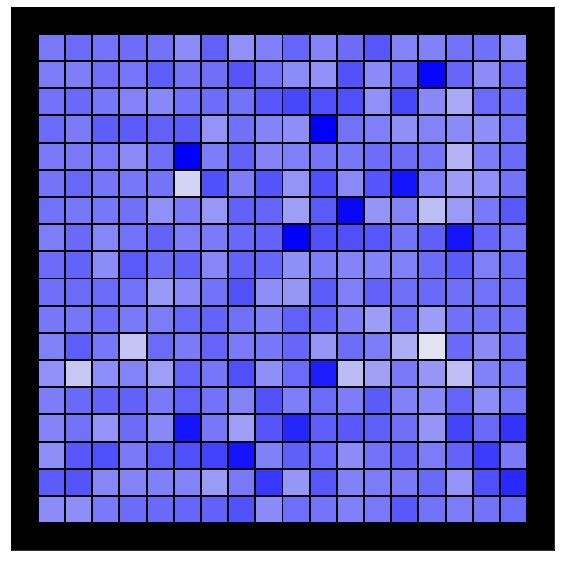

In [ ]:
R = getAllRewards()
# print("r.size =", r.size())
R = R.resize((R.size(1)))
c = plotStates(env.getGrid(), R, True)
plotStatesSmall(c)

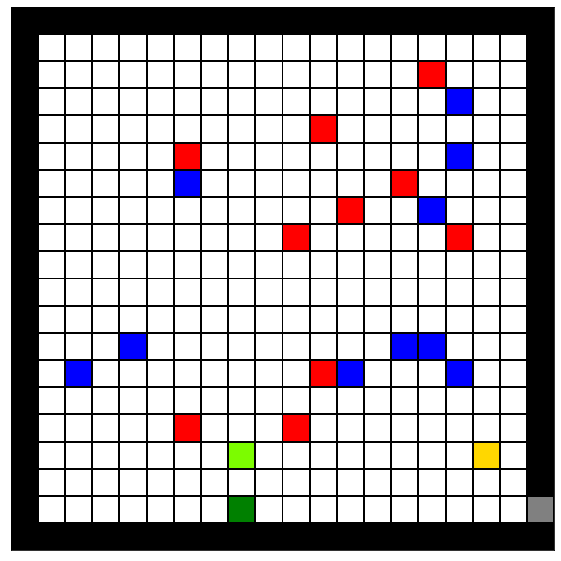

In [ ]:
env.plotGrid(env.getGrid())

## Policy Evaluation & Improvement 

In [ ]:
def improvePolicy(policy, Q, state, eps=0.1):
    q = torch.tensor([Q[state][0], Q[state][1], Q[state][2], Q[state][3], Q[state][4], Q[state][5], Q[state][6], Q[state][7]])

    policy[state] = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    idx = 0
    _, indices = torch.sort(q, descending=True)
    policy[state][indices[idx]] = (1.0-eps)

    num_actions = 8.0
    policy[state][0] += (eps/num_actions)
    policy[state][1] += (eps/num_actions)
    policy[state][2] += (eps/num_actions)
    policy[state][3] += (eps/num_actions)
    policy[state][4] += (eps/num_actions)
    policy[state][5] += (eps/num_actions)
    policy[state][6] += (eps/num_actions)
    policy[state][7] += (eps/num_actions)  
    return policy

In [ ]:
def plotPolicy(grid, plot_size, width_factor=0.075):
    cm = matplotlib.colors.ListedColormap(['black', 'white', 'blue', 'red', 'green', 'gold', 'lawngreen', 'grey', 'aqua', 'pink', 'brown'])
    plt.figure(figsize=(plot_size, plot_size))
    plt.pcolormesh(grid, edgecolors='black', cmap=cm, vmin=0.0, vmax=1.0)
    plt.axes().set_aspect('equal')
    plt.xticks([])
    plt.yticks([])
    
    for s in range(env.side_length**2):
        if (to_coord(env.side_length, s) in env.walls) or (to_coord(env.side_length,s)==env.door):
            continue
        actions = agent.policy[s]
        # print("s =", s, "actions =", actions)
        a = np.argmax(actions)
        # print("s =", s, "actions =", actions, "a =", a)
        x,y = to_coord(env.side_length, s)
        if a==0:
            plt.arrow(x+0.5, y+0.7, 0.0, 0.8, width=width_factor, head_width=2.5*width_factor, head_length=2*width_factor, length_includes_head=True, color='brown')
        elif a==1:
            plt.arrow(x+0.7, y+0.7, 0.7, 0.7, width=width_factor, head_width=2.5*width_factor, head_length=2*width_factor, length_includes_head=True, color='brown')
        elif a==2:
            plt.arrow(x+0.7, y+0.5, 0.8, 0.0, width=width_factor, head_width=2.5*width_factor, head_length=2*width_factor, length_includes_head=True, color='brown')
        elif a==3:
            plt.arrow(x+0.7, y+0.3, 0.7, -0.7, width=width_factor, head_width=2.5*width_factor, head_length=2*width_factor, length_includes_head=True, color='brown')
        elif a==4:
            plt.arrow(x+0.5, y+0.3, 0.0, -0.8, width=width_factor, head_width=2.5*width_factor, head_length=2*width_factor, length_includes_head=True, color='brown')
        elif a==5:
            plt.arrow(x+0.3, y+0.3, -0.7, -0.7, width=width_factor, head_width=2.5*width_factor, head_length=2*width_factor, length_includes_head=True, color='brown')
        elif a==6:
            plt.arrow(x+0.3, y+0.5, -0.8, 0.0, width=width_factor, head_width=2.5*width_factor, head_length=2*width_factor, length_includes_head=True, color='brown')
        else:
            plt.arrow(x+0.3, y+0.7, -0.7, 0.7, width=width_factor, head_width=2.5*width_factor, head_length=2*width_factor, length_includes_head=True, color='brown')
    
    
    plt.show()

### SARSA

In [ ]:
def SARSA(NUM_ITER = 150):
    Q = {}
    for i in range(1,env.side_length-1):
        for j in range(1,env.side_length-1):
            u = to_node_idx(env.side_length, i, j)
            Q[u] = {}
            Q[u][0] = torch.rand(1)
            Q[u][1] = torch.rand(1)
            Q[u][2] = torch.rand(1)
            Q[u][3] = torch.rand(1)
            Q[u][4] = torch.rand(1)
            Q[u][5] = torch.rand(1)
            Q[u][6] = torch.rand(1)
            Q[u][7] = torch.rand(1)
    agent.initializePolicy()
    R = getAllRewards()
    R = R.reshape((R.size(1)))


    cum_reward_S = []
    epsilon = 0.98
    alpha = 0.98
    NUM_PLAYS = (env.side_length-2)**2

    for iter in range(1,NUM_ITER+1):
        agent.resetBuffer()
        env.episode_length = 8
        for x in range(1,env.side_length-1):
            for y in range(1,env.side_length-1):
                env.init_x,env.init_y = x,y
                agent.init_state = (x,y)
                agent.reset()
                env.resetTime()
                ep = agent.playEpisode(env)

        states = agent.experience[0]
        actions = agent.experience[1]
        rewards = agent.experience[2]
        im_rewards = [[float(R[state]) for state in ep] for ep in states] # predicted immediate rewards

        # Remove multiple rewards
        for i,ep in enumerate(states):
            visited_states = set()
            for j,s in enumerate(ep):
                if j==len(ep)-1:
                    break
                if s in visited_states:
                    im_rewards[i][j+1] = 0.0
                else:
                    visited_states.add(s)
        
        for i,ep in enumerate(states):
            for j in range(len(ep)-2):
                s = states[i][j]
                a = actions[i][j]
                r = im_rewards[i][j+1]
                sprime = states[i][j+1]
                aprime = actions[i][j+1]
                
                vis_prev = False
                for k in range(j):
                    if states[i][k]==s and actions[i][k]==a:
                        vis_prev = True
                        break
                if vis_prev:
                    continue
                
                Q[s][a] += alpha*(r + Q[sprime][aprime] - Q[s][a])
                agent.policy = improvePolicy(agent.policy, Q, s, epsilon)
        
        alpha *= 0.98
        epsilon *= 0.98

        rewards = torch.tensor(rewards).to(DEVICE)
        cm = float(torch.sum(rewards))/float(NUM_PLAYS)
        cum_reward_S.append(cm)

        print("iter : "+str(iter)+" |  cum_reward : "+str(cum_reward_S[-1]))

    return cum_reward_S

In [ ]:
cum_reward_S = SARSA()

iter : 1 |  cum_reward : 0.08179012345679013
iter : 2 |  cum_reward : 0.10802469135802469
iter : 3 |  cum_reward : 0.11419753086419752
iter : 4 |  cum_reward : 0.09567901234567901
iter : 5 |  cum_reward : 0.047839506172839504
iter : 6 |  cum_reward : 0.15895061728395063
iter : 7 |  cum_reward : 0.16666666666666666
iter : 8 |  cum_reward : 0.1743827160493827
iter : 9 |  cum_reward : 0.1419753086419753
iter : 10 |  cum_reward : 0.1712962962962963
iter : 11 |  cum_reward : 0.21141975308641975
iter : 12 |  cum_reward : 0.2808641975308642
iter : 13 |  cum_reward : 0.2191358024691358
iter : 14 |  cum_reward : 0.2777777777777778
iter : 15 |  cum_reward : 0.2700617283950617
iter : 16 |  cum_reward : 0.3148148148148148
iter : 17 |  cum_reward : 0.2993827160493827
iter : 18 |  cum_reward : 0.36419753086419754
iter : 19 |  cum_reward : 0.2654320987654321
iter : 20 |  cum_reward : 0.4243827160493827
iter : 21 |  cum_reward : 0.3595679012345679
iter : 22 |  cum_reward : 0.44753086419753085
iter : 2

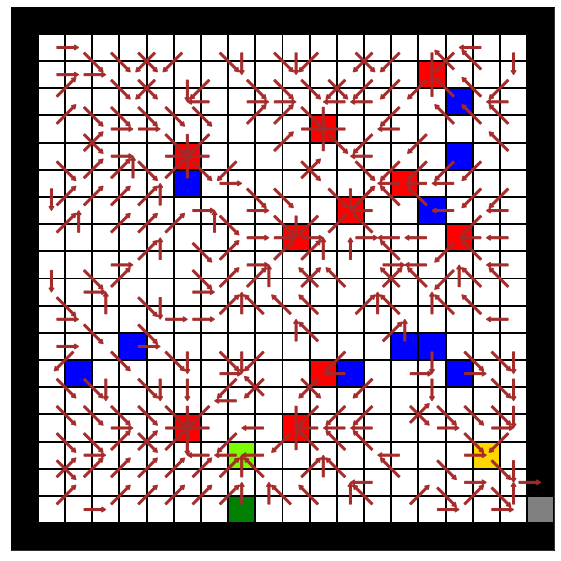

In [ ]:
plotPolicy(env.getGrid(), env.plot_size)